In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import pickle
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from pmdarima import auto_arima

In [2]:
EXCHANGE_RATE = ['GBPUSD=X']
START_DATE = '2019-09-16'
END_DATE = '2022-09-16'

In [3]:
df = yf.download(EXCHANGE_RATE,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

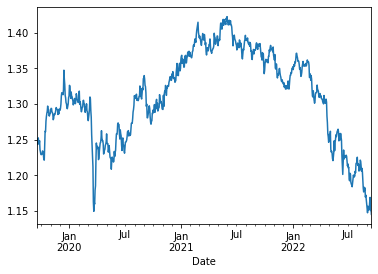

In [4]:
df['Adj Close'].plot()

In [5]:
df['Adj Close'].describe()

count    785.000000
mean       1.310054
std        0.063648
min        1.145265
25%        1.258511
50%        1.311458
75%        1.364927
max        1.422678
Name: Adj Close, dtype: float64

In [6]:
r = df['Adj Close'].pct_change().dropna()
r.name = 'USD/GBP'

In [7]:
r.head()

Date
2019-09-17   -0.005506
2019-09-18    0.005964
2019-09-19   -0.002569
2019-09-20    0.004371
2019-09-23   -0.004241
Name: USD/GBP, dtype: float64

<AxesSubplot:xlabel='Date'>

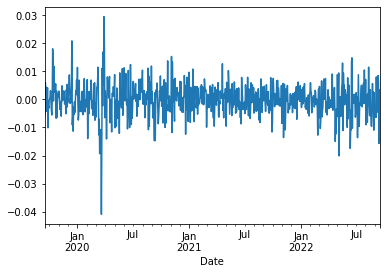

In [8]:
r.plot()

<AxesSubplot:title={'center':'USD/GBP returns: 2019-09-16 - 2022-09-16'}, xlabel='Date'>

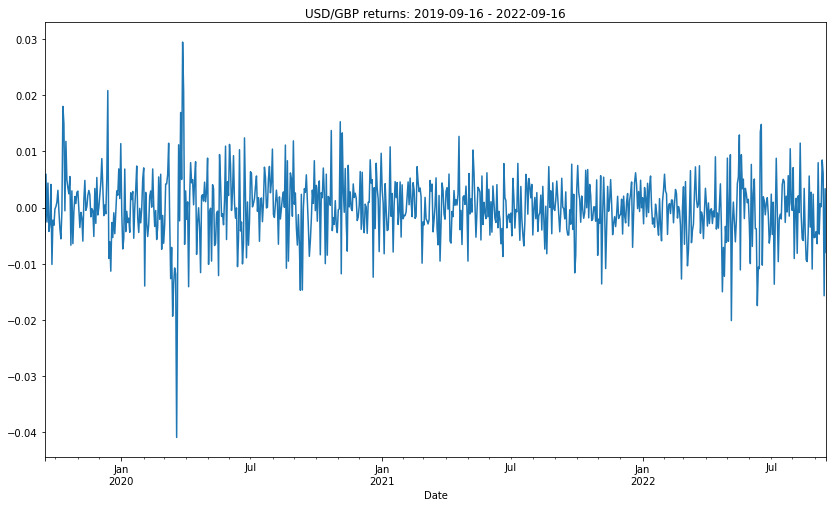

In [9]:
plt.figure(figsize=(14,8))
r.plot(title=f'{r.name} returns: {START_DATE} - {END_DATE}')

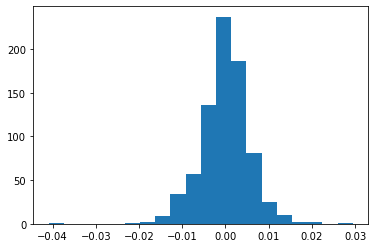

In [10]:
plt.hist(r, bins=20)
plt.show()

<AxesSubplot:xlabel='Date'>

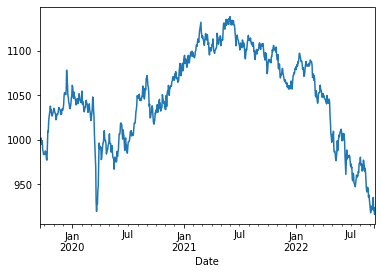

In [11]:
wealth_index=1000*(1+r).cumprod()
wealth_index.plot()

<AxesSubplot:xlabel='Date'>

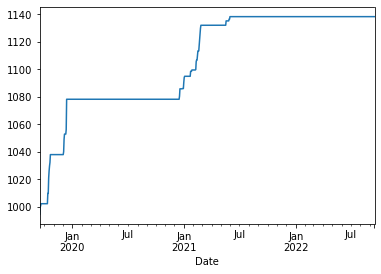

In [12]:
previous_peaks=wealth_index.cummax()
previous_peaks.plot()

<AxesSubplot:xlabel='Date'>

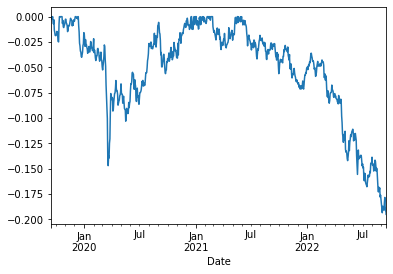

In [13]:
drawdown = (wealth_index - previous_peaks)/previous_peaks
drawdown.plot()

In [14]:
drawdown.min()

-0.19499292961354223

<AxesSubplot:xlabel='Date'>

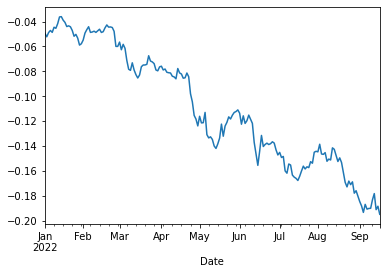

In [15]:
drawdown["2022":].plot()

In [16]:
drawdown["2019":"2020"].min()

-0.1470016750003838

In [17]:
drawdown["2019":"2020"].idxmin()

Timestamp('2020-03-20 00:00:00')

In [18]:
data_insample=r['2017-09-16':'2022-05-31']

In [19]:
data_outsample=r['2022-06-01':'2022-09-16']

In [20]:
acf,q,pval = smt.acf(data_insample, nlags=20, qstat=True)
pacf = smt.pacf(data_insample, nlags=20)
correlogram = pd.DataFrame({'acf':acf[1:],
                           'pacf':pacf[1:],
                           'p-val':pval})
correlogram

,acf,pacf,p-val
0,0.085601,0.085722,0.022649
1,0.081187,0.074617,0.007172
2,0.033146,0.020700,0.013737
3,-0.007722,-0.018314,0.030166
4,-0.004980,-0.007212,0.057301
5,-0.099946,-0.099890,0.006620
6,-0.087352,-0.072727,0.001508
7,-0.069348,-0.044127,0.000781
8,-0.038772,-0.014007,0.001019
9,-0.037366,-0.023801,0.001327


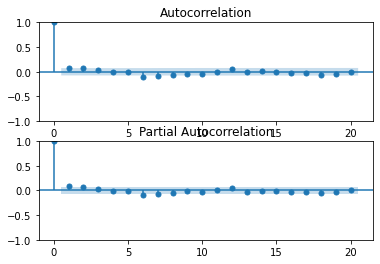

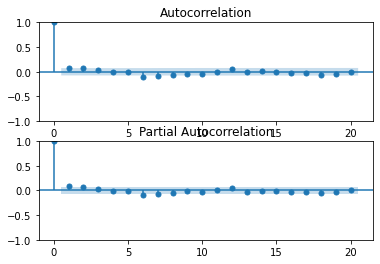

In [21]:
N_LAGS = 20
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2,1)
plot_acf(data_insample, ax=ax[0], lags=N_LAGS,
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(data_insample, ax=ax[1], lags=N_LAGS,
          alpha=SIGNIFICANCE_LEVEL, method='ywm')

In [22]:
def adf_test(x):
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
        return results

In [23]:
adf_test(data_insample)

Test Statistic           -1.126388e+01
p-value                   1.597214e-20
# of Lags Used            6.000000e+00
# of Observations Used    6.990000e+02
Critical Value (1%)      -3.439740e+00
dtype: float64

In [24]:
def kpss_test(x, h0_type='c'):
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
        return results

In [25]:
kpss_test(data_insample)

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic          0.148804
p-value                 0.100000
# of Lags               6.000000
Critical Value (10%)    0.347000
dtype: float64

In [26]:
res = smt.ARIMA(data_insample.asfreq('B'), order=(1,0,0)).fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                USD/GBP   No. Observations:                  706
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2662.039
Date:                Mon, 19 Sep 2022   AIC                          -5318.078
Time:                        00:18:08   BIC                          -5304.399
Sample:                    09-17-2019   HQIC                         -5312.792
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.246e-05      0.000      0.140      0.889      -0.000       0.000
ar.L1          0.0856      0.028      3.071      0.002       0.031       0.140
sigma2      3.108e-05   9.42e-07     32.992      0.0

In [27]:
print(res.aic)

-5318.077619425984


In [28]:
print(res.bic)

-5304.398773713505


In [29]:
smt.ArmaProcess.from_estimation(res).isinvertible

True

In [30]:
smt.ArmaProcess.from_estimation(res).isstationary

True

In [31]:
res = smt.ARIMA(data_insample.asfreq('B'), order=(3,0,0)).fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                USD/GBP   No. Observations:                  706
Model:                 ARIMA(3, 0, 0)   Log Likelihood                2664.139
Date:                Mon, 19 Sep 2022   AIC                          -5318.277
Time:                        00:18:08   BIC                          -5295.479
Sample:                    09-17-2019   HQIC                         -5309.468
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.188e-05      0.000      0.123      0.902      -0.000       0.001
ar.L1          0.0801      0.031      2.606      0.009       0.020       0.140
ar.L2          0.0719      0.028      2.602      0.0

In [32]:
stepwise_fit=auto_arima(data_insample, trace=True, sppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5315.616, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5314.885, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5318.077, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5317.370, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5316.861, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-5319.983, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-5318.277, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5318.024, Time=0.54 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5317.213, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-5316.296, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-5321.966, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5320.058, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-5320.261, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5320.002, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  706
Model:               SARIMAX(2, 0, 0)   Log Likelihood                2663.983
Date:                Mon, 19 Sep 2022   AIC                          -5321.966
Time:                        00:18:11   BIC                          -5308.287
Sample:                    09-17-2019   HQIC                         -5316.680
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0809      0.029      2.787      0.005       0.024       0.138
ar.L2          0.0743      0.027      2.720      0.007       0.021       0.128
sigma2      3.089e-05   9.76e-07     31.649      0.000     2.9e-05    3.28e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               687.06
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
res = smt.ARIMA(data_insample.asfreq('B'), order=(2,0,0)).fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                USD/GBP   No. Observations:                  706
Model:                 ARIMA(2, 0, 0)   Log Likelihood                2663.991
Date:                Mon, 19 Sep 2022   AIC                          -5319.983
Time:                        00:18:12   BIC                          -5301.744
Sample:                    09-17-2019   HQIC                         -5312.935
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.254e-05      0.000      0.130      0.897      -0.000       0.001
ar.L1          0.0809      0.029      2.780      0.005       0.024       0.138
ar.L2          0.0743      0.027      2.714      0.0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
def rmse(pred, target):
    return np.sqrt((pred - target)**2).mean()

pred = res.predict('2022-06-01','2022-09-16',dynamic=False)
stats1 = rmse(pred, data_outsample)
print('root mean squared error1: {}'.format(stats1))

stats2 = sqrt(mean_squared_error(data_outsample, pred))
print('root mean squared error2: {}'.format(stats2))

root mean squared error1: 0.0052999667784882475
root mean squared error2: 0.006670469098959676


In [35]:
start=len(data_insample)
end=len(data_insample)+len(data_outsample)-1
pred=res.predict(start='2022-06-01', end='2022-09-16', type='levels')
print(pred)

2022-06-01    0.000212
2022-06-02    0.000155
2022-06-03    0.000056
2022-06-06    0.000043
2022-06-07    0.000035
                ...   
2022-09-12    0.000033
2022-09-13    0.000033
2022-09-14    0.000033
2022-09-15    0.000033
2022-09-16    0.000033
Freq: B, Name: predicted_mean, Length: 78, dtype: float64


<AxesSubplot:xlabel='Date'>

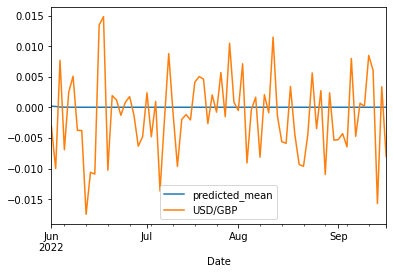

In [36]:
pred.plot(legend=True)
data_outsample.plot(legend=True)

In [37]:
rmse = sqrt(mean_squared_error(pred, data_outsample))
print(rmse)

0.006670469098959676


In [38]:
pred2=res.predict(start='2022-09-17', end='2022-12-16', type='levels').rename('ARIMA Predictions')
print(pred2)

2022-09-19    0.000033
2022-09-20    0.000033
2022-09-21    0.000033
2022-09-22    0.000033
2022-09-23    0.000033
                ...   
2022-12-12    0.000033
2022-12-13    0.000033
2022-12-14    0.000033
2022-12-15    0.000033
2022-12-16    0.000033
Freq: B, Name: ARIMA Predictions, Length: 65, dtype: float64


<AxesSubplot:>

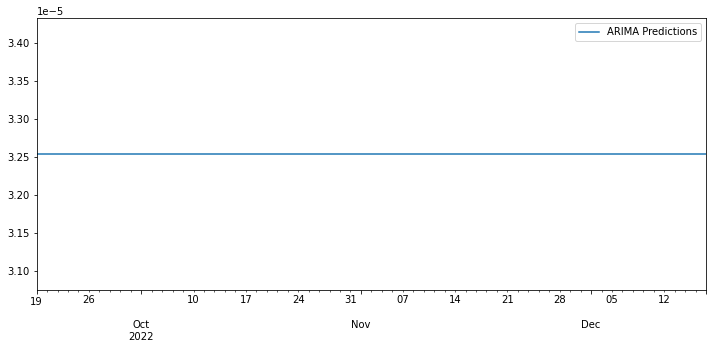

In [39]:
pred2.plot(figsize=(12,5), legend=True)